# Keyness Metrics (for Lemmatized Corpora)

With this notebook, you can replicate the numbers and figures from our paper.

Setup...

In [1]:
from src.corpus import Corpus
from src.metrics import keyness
from src.corpus_creation import document_retriever as dr
from src.corpus_creation import handle_wordlists as hw
from src.load_data import load_files
from src.corpus_creation import handle_wordlists
from src.metrics import rqtr_lemma
import pandas as pd


%load_ext autoreload
%autoreload 2

Loading the data...

Put the path to your corpus in the variable `CORPUSDIR`.

I assume that the data is a set of json files, each containing a list of lemmata under the key 'lemmas'.
If you have a different format, you need to adjust the code accordingly. The result should be a list of lists of lemmata.

In [2]:
# Put the path to the directory containing the corpus files here
CORPUSDIR = '/home/brunobrocai/Data/MoWiKo/Paper-themKorp-2/final_corpus'

docs, metadata = load_files(CORPUSDIR)
corpus = Corpus(docs, metadata)

We define two sets of core terms.

In [3]:
core_terms = [
    [('künstlich', 'Intelligenz'), ('KI',)],
    [('künstlich', 'Intelligenz'), ('Roboter',), ('Chatbot',)],
]

With the two core term sets, we create two study/reference corpora.

In [4]:
study_ref_corpora = {}
for i, core_term in enumerate(core_terms):
    hits = dr.match_wordlist(
        corpus, core_term, min=1
    )

    study_corpus = dr.corpus_from_found(
        hits, source_corpus=corpus,
        goal_corpus='FrequencyCorpus'
    )
    reference_corpus = dr.corpus_from_notfound(
        hits, source_corpus=corpus,
        goal_corpus='FrequencyCorpus'
    )
    study_ref_corpora[i] = (study_corpus, reference_corpus)

Next, define some (admitedly, long and inelegant) functions to calculate the keyness metrics and execute them.

In [14]:
wordlists = {}

def keyness_query(study_corpus, reference_corpus, method, core_terms):
    keynesses = keyness.keyword_list(
        study_corpus, reference_corpus,
        metric=method,
        min_docs=5,
        smoothing=0.0001,
        max_ngram_len=2,
        filter_stopwords=True,
    )
    if method == 'odds_ratio':
        filtered_df = keynesses[(keynesses['Keyness'] > 1.0)]
    elif method == 'log_likelihood_rayson':
        filtered_df = keynesses[(keynesses['Keyness'] > 15.13)]

    filtered_df = hw.top_x_with_core(50, 'Keyness', filtered_df, core_terms)

    wordlist = filtered_df['Term'].tolist()
    # add core terms to the wordlist that are not already there
    wordlist = list(set(wordlist + core_terms))
    return wordlist

def rqtr(
    full_corpus,
    study_corpus, reference_corpus,
    core_terms,
):
    b, core_term =rqtr_lemma.qtr_baseline(
        core_terms, full_corpus
    )
    cooccurence_values = rqtr_lemma.count_cooccurence(
        core_terms,
        full_corpus,
        max_ngram_len=2,
    )
    rqtrn_table = rqtr_lemma.cooccurence_to_metric(
        cooccurence_values,
        b,
        metric='rqtrn',
        min_docs=5,
    )
    keynesses = keyness.keyword_list(
        study_corpus, reference_corpus,
        metric='log_likelihood_rayson',
        min_docs=5,
        smoothing=0.0001,
        max_ngram_len=2,
        filter_stopwords=True,
    )
    filtered_df = rqtrn_table[(rqtrn_table['RQTRN'] > 0)]

    # Add column LL and then filter
    filtered_df['LL'] = rqtrn_table['Term'].map(
        keynesses.set_index('Term')['Keyness']
    )
    filtered_df = filtered_df[filtered_df['LL'] > 15.13]

    filtered_df = hw.top_x_with_core(50, 'RQTRN', filtered_df, core_terms)

    wordlist = filtered_df['Term'].tolist()
    # add core terms to the wordlist that are not already there
    wordlist = list(set(wordlist + core_terms))

    return wordlist

wordlists['rqtr'] = rqtr(
    corpus,
    study_ref_corpora[0][0], study_ref_corpora[0][1],
    core_terms[0],
)
wordlists['rqtr_BT2'] = rqtr(
    corpus,
    study_ref_corpora[1][0], study_ref_corpora[1][1],
    core_terms[1],
)
for method in ['odds_ratio', 'log_likelihood_rayson']:
    wordlists[method] = keyness_query(
        study_ref_corpora[0][0], study_ref_corpora[0][1],
        method,
        core_terms[0]
    )
    wordlists[method + '_BT2'] = keyness_query(
        study_ref_corpora[1][0], study_ref_corpora[1][1],
        method,
        core_terms[1]
    )

Term ('künstlich', 'Intelligenz'): 128, QTR: 0.4765625
Term ('KI',): 87, QTR: 0.7011494252873564

Co-occurrence counts:
Co-occurrence (('künstlich', 'Intelligenz'), ('KI',)): 61
Co-occurrence (('KI',), ('künstlich', 'Intelligenz')): 61

QTR values:
QTR(('künstlich', 'Intelligenz')): 0.4765625
QTR(('KI',)): 0.7011494252873564

Baseline term (with lowest QTR): ('künstlich', 'Intelligenz')


Finding relevant documents with the core term: 100%|██████████| 6737/6737 [00:00<00:00, 7483.75it/s]


Found 22182 words in the corpus coocurring with {('künstlich', 'Intelligenz'), ('KI',)}


Finding relevant documents with the core term: 100%|██████████| 6737/6737 [00:00<00:00, 8029.87it/s]


Found 43769 words in the corpus coocurring with {('künstlich', 'Intelligenz'), ('KI',)}


/home/brunobrocai/Code/Paper-themKorpus/RQTR/src/metrics/keyness.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, n_df], ignore_index=True)
/tmp/ipykernel_123000/480344122.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LL'] = rqtrn_table['Term'].map(


Term ('künstlich', 'Intelligenz'): 128, QTR: 0.1875
Term ('Roboter',): 26, QTR: 0.23076923076923078
Term ('Chatbot',): 26, QTR: 0.7692307692307693

Co-occurrence counts:
Co-occurrence (('künstlich', 'Intelligenz'), ('Roboter',)): 24
Co-occurrence (('künstlich', 'Intelligenz'), ('Chatbot',)): 24
Co-occurrence (('Roboter',), ('künstlich', 'Intelligenz')): 6
Co-occurrence (('Roboter',), ('Chatbot',)): 6
Co-occurrence (('Chatbot',), ('künstlich', 'Intelligenz')): 20
Co-occurrence (('Chatbot',), ('Roboter',)): 20

QTR values:
QTR(('künstlich', 'Intelligenz')): 0.1875
QTR(('Roboter',)): 0.23076923076923078
QTR(('Chatbot',)): 0.7692307692307693

Baseline term (with lowest QTR): ('künstlich', 'Intelligenz')


Finding relevant documents with the core term: 100%|██████████| 6737/6737 [00:00<00:00, 6961.84it/s]


Found 19718 words in the corpus coocurring with {('Roboter',), ('Chatbot',), ('künstlich', 'Intelligenz')}


Finding relevant documents with the core term: 100%|██████████| 6737/6737 [00:00<00:00, 7900.71it/s]


Found 37605 words in the corpus coocurring with {('Roboter',), ('Chatbot',), ('künstlich', 'Intelligenz')}


/home/brunobrocai/Code/Paper-themKorpus/RQTR/src/metrics/keyness.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, n_df], ignore_index=True)
/tmp/ipykernel_123000/480344122.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LL'] = rqtrn_table['Term'].map(
/home/brunobrocai/Code/Paper-themKorpus/RQTR/src/metrics/keyness.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longe

The pre-defined queries we can just load from `custom_queries.py`.

In [6]:
from src.misc import custom_queries

wordlists['Baseline'] = custom_queries.BASELINE
wordlists['Subjective (1)'] = custom_queries.SUBJECTIVE_1
wordlists['Subjective (2)'] = custom_queries.SUBJECTIVE_2
wordlists['LLM-Regex'] = custom_queries.KI_REGEX_LLM

The collocations are also best loaded from a file because they take long to compute. If you want to replicate this part, head over to the `collocations.ipynb` notebook and run the code there.

In [13]:
# Counting the cooccurences takes a longer time, so we load precomputed values

def load_collocs_csv(
    filename,
    base_terms=[('künstlich', 'Intelligenz'), 'KI']
):
    df = pd.read_csv(filename)
    df = df[df['Doc_Freq'] > 4]
    filtered_df = hw.top_x_with_core(50, 'Stat', df, core_terms[0])
    wordlist = filtered_df['Term'].tolist()
    return wordlist


wordlists['coll-Absatz-logdice'] = load_collocs_csv('wordlists_old/collocations-Absatz-logice-Run2.csv')
wordlists['coll-Absatz-npmi'] = load_collocs_csv('wordlists_old/collocations-Absatz-npmi-Run2.csv')
wordlists['coll-5-logdice'] = load_collocs_csv('wordlists_old/collocations-5-logice-Run2.csv')
wordlists['coll-5-npmi'] = load_collocs_csv('wordlists_old/collocations-5-npmi-Run2.csv')

Let's save the resulting wordlists so that we can inspect them later.

In [ ]:
import os
# Save the wordlists to files

GOALDIR = 'wordlists/'
for name, wordlist in wordlists.items():
    if isinstance(wordlist, str):
        wordlist = [wordlist]
    filename = GOALDIR + name + '.txt'
    if os.path.exists(filename):
        print(f'File {filename} already exists. Skipping.')
        continue
    with open(filename, 'w') as f:
        for term in wordlist:
            f.write(str(term) + '\n')
    print(f'Wordlist {name} saved to {GOALDIR + name}.txt')

Next, define a function that evaluates the queries at different absolute frequency thesholds and run it.

Looking at thresholds from 1 to 30 is enough to see all relevant phenomena.

In [ ]:
import re

def results_for_methods(
    wordlists: dict, corpus: Corpus, topics: list,
    min_min: int = 1, max_min: int = 30,
):
    results = {}
    for method, wordlist in wordlists.items():
        if 'Subjective' in method:
            hits = dr.match_wordlist(
                corpus, wordlist, min=1,
                escape=False, flags=re.IGNORECASE,
            )
        elif method == 'LLM-Regex':
            hits = dr.match_regex(
                corpus, wordlist, min=1,
            )
        else:
            hits = dr.match_wordlist(
                corpus, wordlist, min=1,
            )
        result = dr.eval_min(
            corpus, hits, 'gold_label',
            min_min=min_min,
            max_min=max_min,
            topic=topics,
        )
        results[method] = result
    return results

results_maintpc = results_for_methods(
    wordlists, corpus, topics=['1_hauptthema'],
    min_min=1, max_min=30,
)
results_sidetpc = results_for_methods(
    wordlists, corpus, topics=['1_hauptthema', '2_nebenthema'],
    min_min=1, max_min=30,
)

Next, define a function to plot the results as a line graph and run it for main and side topic queries.

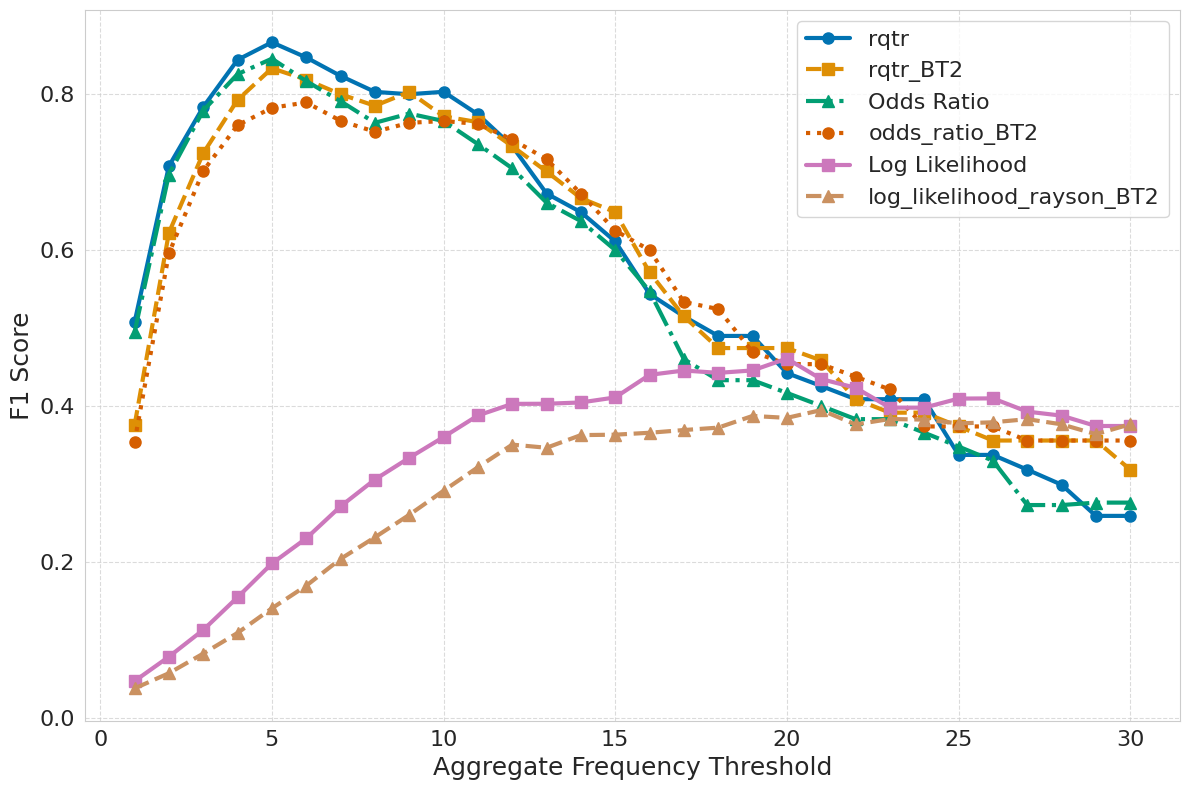

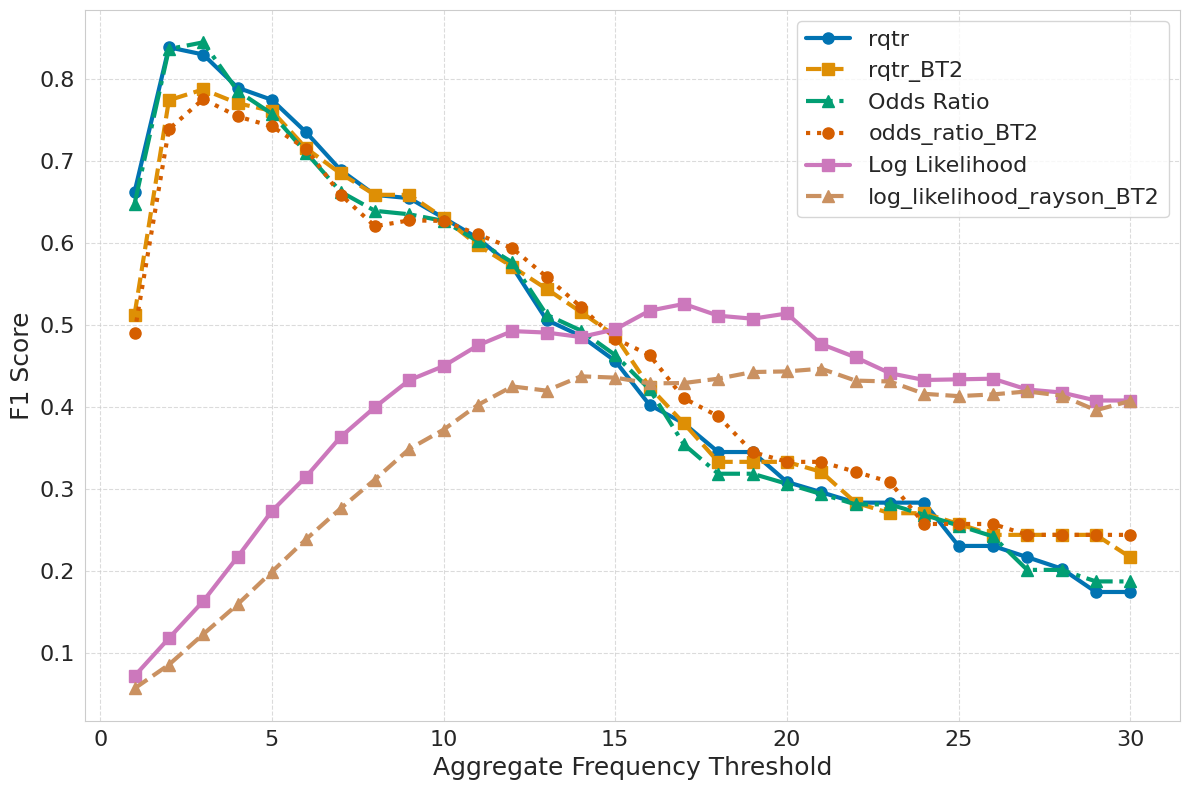

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns


def print_plot(
    results: dict, skip_methods: list = None,
    xlabel: str = 'Aggregate Frequency Threshold',
    ylabel: str = 'F1 Score',
):
    # Translate some method names to more readable names
    metric_to_name = {
        'odds_ratio': 'Odds Ratio',
        'log_likelihood_rayson': 'Log Likelihood',
        'RQTR': 'RQTR',
        'Baseline': 'Baseline',
        'Subjective (2)': 'Subjective (2)',
        'coll-Absatz-logdice': 'Paragraph-wide LogDice',
        'coll-Absatz-npmi': 'Paragraph-wide nPMI',
    }
    plt.figure(figsize=(12, 8))

    # Set the style and use a colorblind-friendly palette
    sns.set_style("whitegrid")
    palette = sns.color_palette("colorblind")
    line_styles = ['-', '--', '-.', ':']
    marker_styles = ['o', 's', '^']

    for idx, (method, result) in enumerate(results.items()):
        if method in skip_methods:
            continue
        i_values = list(result.keys())
        f1_values = [result[i]['f1-score'] for i in i_values]
        plt.plot(
            i_values, f1_values,
            label=f'{metric_to_name.get(method, method)}',
            color=palette[idx],
            linestyle=line_styles[idx % len(line_styles)],
            linewidth=3,
            marker=marker_styles[idx % len(marker_styles)],
            markersize=8
        )

    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.legend(fontsize=16, frameon=True)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.tight_layout()
    plt.savefig('classification_metrics.png', dpi=300)
    plt.show()


print_plot(
    results_maintpc,
    skip_methods=[
        'Subjective (1)',
        'coll-5-logdice',
        'coll-5-npmi',
    ]
)
print_plot(
    results_sidetpc,
    skip_methods=[
        'Subjective (1)',
        'coll-5-logdice',
        'coll-5-npmi',
    ]
)

Same as above (test for different thresholds and then visualize) but for PMW.

In [20]:
def results_for_methods_pmw(
    wordlists: dict, corpus: Corpus, topics: list,
    min_min: int = 500, max_min: int = 5000,
    step: int = 500,
):
    results = {}
    for method, wordlist in wordlists.items():

        if 'Subjective' in method:
            hits = dr.match_wordlist_pmw(
                corpus, wordlist, min_pmw=1,
                escape=False, flags=re.IGNORECASE,
            )
        elif method == 'LLM-Regex':
            hits = dr.match_regex_pmw(
                corpus, wordlist, min_pmw=1,
            )
        else:
            hits = dr.match_wordlist_pmw(
                corpus, wordlist, min_pmw=1,
            )

        result = dr.eval_min_pmw(
            corpus, hits, 'gold_label',
            min_min=min_min,
            max_min=max_min,
            steps=step,
            topic=topics,
        )

        results[method] = result

    return results

results_pmw_maintpc = results_for_methods_pmw(
    wordlists, corpus, topics=['1_hauptthema'],
    min_min=1000, max_min=50001,
    step=1000,
)
results_pmw_sidetpc = results_for_methods_pmw(
    wordlists, corpus, topics=['1_hauptthema', '2_nebenthema'],
    min_min=1000, max_min=50001,
    step=1000,
)

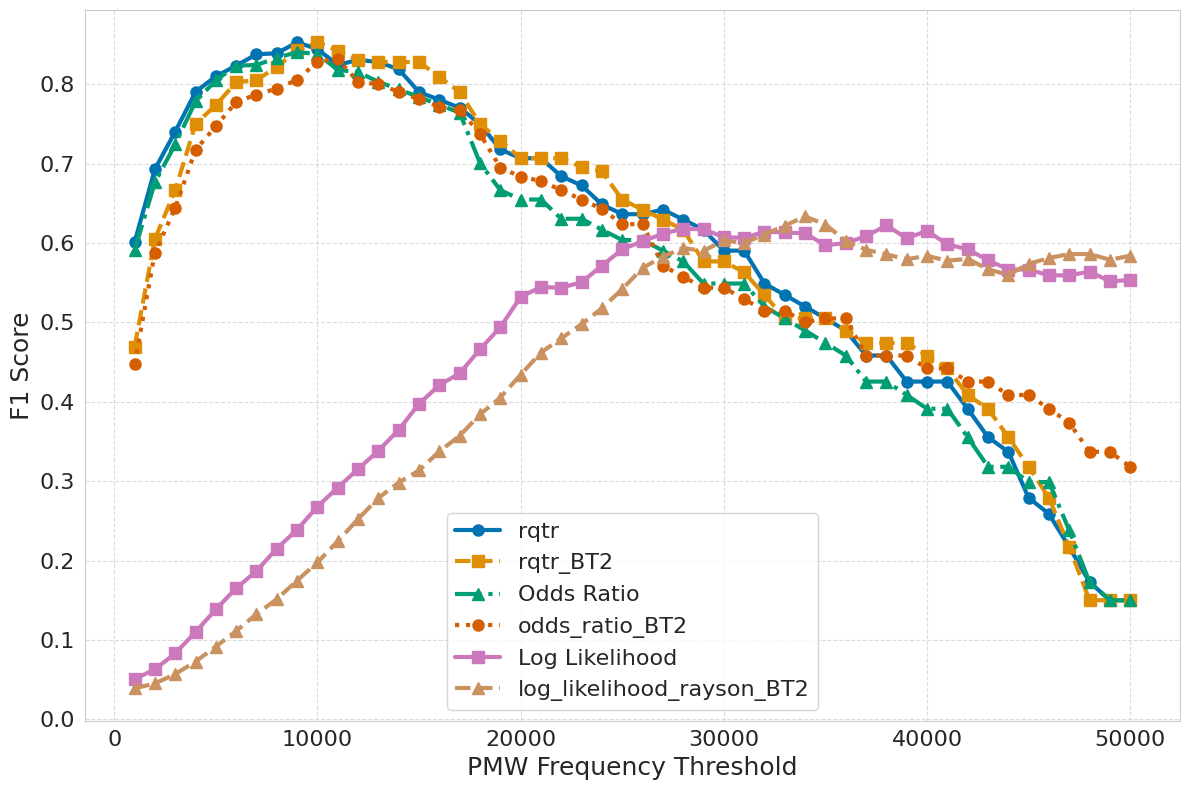

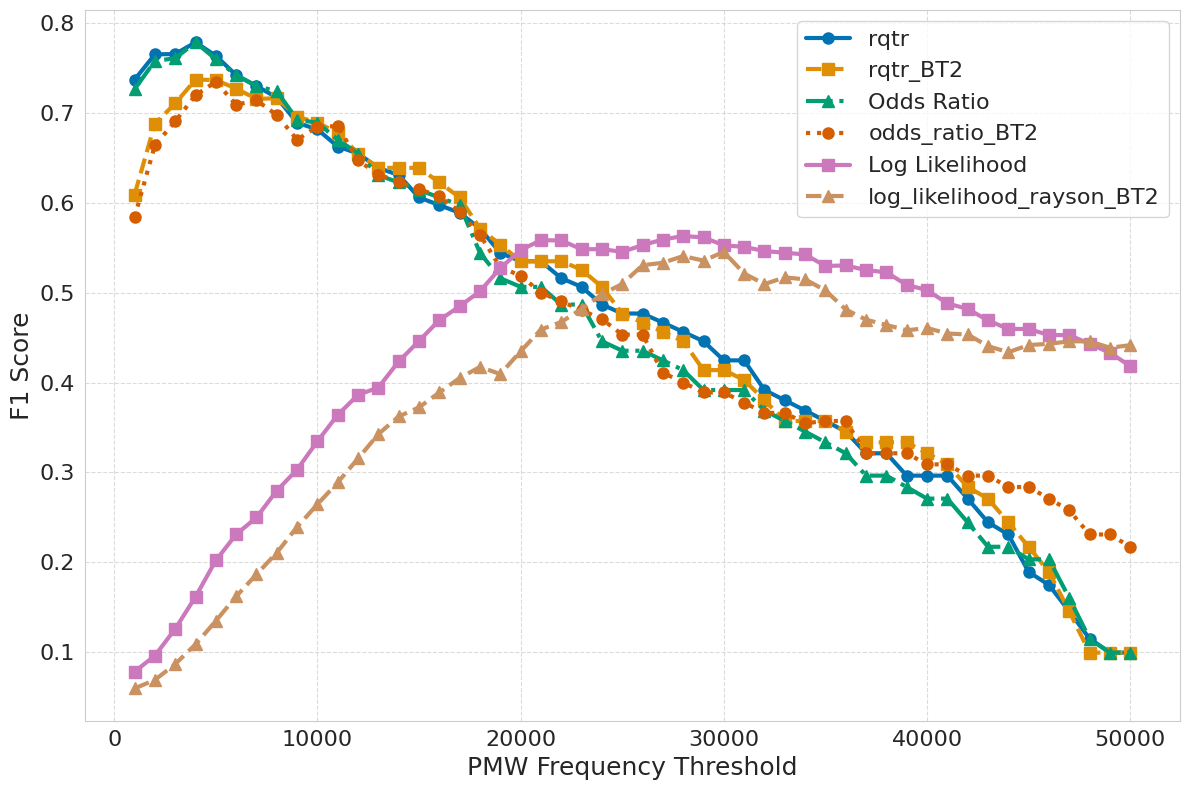

In [37]:
print_plot(
    results_pmw_maintpc,
    skip_methods=[
        'Subjective (1)',
        'coll-5-logdice',
        'coll-5-npmi',
    ],
        xlabel='PMW Frequency Threshold',
)
print_plot(
    results_pmw_sidetpc,
    skip_methods=[
        'Subjective (1)',
        'coll-5-logdice',
        'coll-5-npmi',
    ],
        xlabel='PMW Frequency Threshold',
)


Look at the results in a table...

In [38]:
import pandas as pd


def create_results_df(
    results_maintpc, results_pmw_maintpc, min_thresholds=[1, 3, 5], pmw_value=10000
):
    columns = pd.MultiIndex.from_product([
        [f'min {thresh}' for thresh in min_thresholds] + [f'pmw {pmw_value}'],
        ['precision', 'recall', 'f1-score']
    ])
    df = pd.DataFrame(columns=columns)

    for method, evals in results_maintpc.items():
        row_data = []

        for thresh in min_thresholds:
            row_data.extend([
                evals[thresh]['precision'],
                evals[thresh]['recall'],
                evals[thresh]['f1-score']
            ])

        row_data.extend([
            results_pmw_maintpc[method][pmw_value]['precision'],
            results_pmw_maintpc[method][pmw_value]['recall'],
            results_pmw_maintpc[method][pmw_value]['f1-score']
        ])

        df.loc[method] = row_data

    return df


df = create_results_df(
    results_maintpc,
    results_pmw_maintpc,
    min_thresholds=[1, 5],
    pmw_value=10000
)
df.round(3)
df

min 1                         min 5            \
                          precision    recall  f1-score precision    recall   
rqtr                       0.346535  0.945946  0.507246  0.855263  0.878378   
rqtr_BT2                   0.232258  0.972973  0.375000  0.792683  0.878378   
odds_ratio                 0.334928  0.945946  0.494700  0.840000  0.851351   
odds_ratio_BT2             0.216216  0.972973  0.353808  0.724138  0.851351   
log_likelihood_rayson      0.023950  0.986486  0.046765  0.110577  0.932432   
log_likelihood_rayson_BT2  0.019043  1.000000  0.037374  0.075612  0.959459   

                                    pmw 10000                      
                           f1-score precision    recall  f1-score  
rqtr                       0.866667  0.934426  0.770270  0.844444  
rqtr_BT2                   0.833333  0.935484  0.783784  0.852941  
odds_ratio                 0.845638  0.919355  0.770270  0.838235  
odds_ratio_BT2             0.782609  0.878788  0.783784  0.828571  
log_likelihood_rayson      0.197708  0.156463  0.932432  0.267961  
log_likelihood_rayson_BT2  0.140178  0.110410  0.945946  0.197740

We can also copy and paste them when they are comma-separated (e.g. in Excel, Google Sheets).

In [ ]:
flat_df = df.copy()
flat_df.columns = [f"{col[0]}_{col[1]}" for col in df.columns]
flat_df = flat_df.reset_index().rename(columns={'index': 'method'})

print(flat_df.to_csv(index=False))

method,min 1_precision,min 1_recall,min 1_f1-score,min 5_precision,min 5_recall,min 5_f1-score,pmw 10000_precision,pmw 10000_recall,pmw 10000_f1-score
rqtr,0.347,0.946,0.507,0.855,0.878,0.867,0.934,0.77,0.844
rqtr_BT2,0.232,0.973,0.375,0.793,0.878,0.833,0.935,0.784,0.853
odds_ratio,0.335,0.946,0.495,0.84,0.851,0.846,0.919,0.77,0.838
odds_ratio_BT2,0.216,0.973,0.354,0.724,0.851,0.783,0.879,0.784,0.829
log_likelihood_rayson,0.024,0.986,0.047,0.111,0.932,0.198,0.156,0.932,0.268
log_likelihood_rayson_BT2,0.019,1.0,0.037,0.076,0.959,0.14,0.11,0.946,0.198

